# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----
Define salaries based upon the job description.  

***The HR department doesn't quiet understand how to set salaries for each job.  They would like to predict the job salary based upon the job description. The supplied data will be used to determine how to appropriate set (predict) the salary range for a given job description.***

In [6]:
# import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas_profiling import ProfileReport
import seaborn as sns
from IPython.display import HTML, IFrame
from helperFile import random_tune, MachineLearning
from sklearn.ensemble import RandomForestRegressor

# etc


# your info here
__author__ = "Nicholas Arquette"
__email__ = "nicholas.arquette@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----



In [7]:
# load the data into a Pandas dataframe
train_features = pd.read_csv(os.path.join('../data', 'original', 'train_features.tar.gz'),
                             compression='gzip', header=0, sep=',', low_memory=False)
# drop na columns
train_features.dropna(inplace=True)

# set column name
train_features.columns = ['jobId', 'companyId', 'jobType', 'degree',
                          'major', 'industry', 'yearsExperience', 'milesFromMetropolis']

# load train salaries
train_salaries = pd.read_csv(os.path.join('../data', 'original', 'train_salaries.tar.gz'),
                             compression='gzip', header=0, sep=',', low_memory=False)

# drop na columsn
train_salaries.dropna(inplace=True)

# change the column name
train_salaries.columns = ['jobId', 'salary']

In [8]:
# build a dictionary to store train jobids and salaries
salary_dict = dict(zip(train_features.jobId, train_salaries.salary))

In [9]:
# copy train feature data frame
train_data = train_features.copy()

# add new column to train data
train_data['salary'] = train_salaries['jobId'].apply(
    lambda job_id: salary_dict.get(job_id))

In [10]:
# delete train features and train salaries from memory
del train_features
del train_salaries

In [11]:
# show a few rows of data
train_data.head()

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH             10.0                 83.0   130.0  
1      WEB              3.0                 73.0   101.0  
2   HEALTH             10.0                 38.0   137.0  
3     AUTO              8.0                 17.0   142.0  
4  FINANCE              8.0                 16.0   163.0

In [12]:
# describe the train data set
train_data.describe()

yearsExperience  milesFromMetropolis          salary
count   1000000.000000       1000000.000000  1000000.000000
mean         11.992386            49.529260      116.061818
std           7.212391            28.877733       38.717936
min           0.000000             0.000000        0.000000
25%           6.000000            25.000000       88.000000
50%          12.000000            50.000000      114.000000
75%          18.000000            75.000000      141.000000
max          24.000000            99.000000      301.000000

In [13]:
# look at salaries at zero
train_data.loc[train_data['salary'] <= 0]

jobId companyId         jobType       degree        major  \
30559   JOB1362684438246    COMP44          JUNIOR     DOCTORAL         MATH   
495984  JOB1362684903671    COMP34          JUNIOR         NONE         NONE   
652076  JOB1362685059763    COMP25             CTO  HIGH_SCHOOL         NONE   
816129  JOB1362685223816    COMP42         MANAGER     DOCTORAL  ENGINEERING   
828156  JOB1362685235843    COMP40  VICE_PRESIDENT      MASTERS  ENGINEERING   

       industry  yearsExperience  milesFromMetropolis  salary  
30559      AUTO             11.0                  7.0     0.0  
495984      OIL              1.0                 25.0     0.0  
652076     AUTO              6.0                 60.0     0.0  
816129  FINANCE             18.0                  6.0     0.0  
828156      WEB              3.0                 29.0     0.0

In [14]:
# show the first few rows
train_data.head()

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH             10.0                 83.0   130.0  
1      WEB              3.0                 73.0   101.0  
2   HEALTH             10.0                 38.0   137.0  
3     AUTO              8.0                 17.0   142.0  
4  FINANCE              8.0                 16.0   163.0

In [15]:
# show if there are any null values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   jobId                1000000 non-null  object 
 1   companyId            1000000 non-null  object 
 2   jobType              1000000 non-null  object 
 3   degree               1000000 non-null  object 
 4   major                1000000 non-null  object 
 5   industry             1000000 non-null  object 
 6   yearsExperience      1000000 non-null  float64
 7   milesFromMetropolis  1000000 non-null  float64
 8   salary               1000000 non-null  float64
dtypes: float64(3), object(6)
memory usage: 76.3+ MB


In [16]:
# show the counts by job
train_data.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

In [17]:
# show the counts by Company ID
train_data.companyId.value_counts()

COMP39    16193
COMP35    16114
COMP59    16066
COMP30    16041
COMP3     16028
          ...  
COMP17    15715
COMP0     15666
COMP2     15641
COMP8     15638
COMP57    15635
Name: companyId, Length: 63, dtype: int64

In [18]:
# show the count of features by Degree
train_data.degree.value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [19]:
# show the counts by major
train_data.major.value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [20]:
# show people the major information for those that a degree not equal to high school or none
train_data.loc[(train_data['degree'] != 'HIGH_SCHOOL') |
               (train_data['degree'] != 'NONE'), 'major'].value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [21]:
# show a grouping of data the cout of major and degree
# notice the major of none with having a degree
pd.set_option("display.max_rows", 100)
train_data.groupby(['major', 'degree'])['major', 'degree'].count()


/home/narquette/anaconda/envs/dscience/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


major  degree
major       degree                     
BIOLOGY     BACHELORS     19619   19619
            DOCTORAL      19405   19405
            MASTERS       19355   19355
BUSINESS    BACHELORS     19458   19458
            DOCTORAL      19542   19542
            MASTERS       19518   19518
CHEMISTRY   BACHELORS     19681   19681
            DOCTORAL      19575   19575
            MASTERS       19619   19619
COMPSCI     BACHELORS     19577   19577
            DOCTORAL      19327   19327
            MASTERS       19478   19478
ENGINEERING BACHELORS     19672   19672
            DOCTORAL      19428   19428
            MASTERS       19496   19496
LITERATURE  BACHELORS     19421   19421
            DOCTORAL      19594   19594
            MASTERS       19669   19669
MATH        BACHELORS     19262   19262
            DOCTORAL      19357   19357
            MASTERS       19182   19182
NONE        BACHELORS     19498   19498
            DOCTORAL      19719   19719
            HIGH_SCHOOL  236976  236976
            MASTERS       19308   19308
            NONE         236854  236854
PHYSICS     BACHELORS     19307   19307
            DOCTORAL      19417   19417
            MASTERS       19686   19686

In [22]:
# show the counts by industry
train_data.industry.value_counts()

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

### ---- 3 Clean the data ----

In [23]:
# drop salary data less than or equal to zero
train_data_clean = train_data.copy()
zero_salary = train_data_clean.loc[train_data_clean['salary'] == 0].index
train_data_clean.drop(zero_salary, inplace=True)

# check to see that zero salary items are gone
train_data_clean.loc[train_data_clean['salary'] == 0]



Empty DataFrame
Columns: [jobId, companyId, jobType, degree, major, industry, yearsExperience, milesFromMetropolis, salary]
Index: []

In [24]:
# put the columns to be analyzed in a list
columns = ['companyId', 'jobType', 'degree', 'major', 
           'industry', 'yearsExperience', 'milesFromMetropolis']

# show duplicate values by the list of columns
# if the information is the same for all columns it will show as a duplicate
duplicate = train_data_clean[train_data_clean.duplicated(subset=columns, keep='last') == True]
duplicate


jobId companyId         jobType       degree      major  \
83      JOB1362684407770    COMP17         MANAGER         NONE       NONE   
122     JOB1362684407809    COMP46         JANITOR         NONE       NONE   
216     JOB1362684407903    COMP36         JANITOR         NONE       NONE   
294     JOB1362684407981    COMP37             CEO     DOCTORAL  CHEMISTRY   
302     JOB1362684407989     COMP1         JANITOR         NONE       NONE   
...                  ...       ...             ...          ...        ...   
978443  JOB1362685386130     COMP3         JANITOR  HIGH_SCHOOL       NONE   
982142  JOB1362685389829    COMP38         JANITOR         NONE       NONE   
987233  JOB1362685394920    COMP26             CTO         NONE       NONE   
990353  JOB1362685398040     COMP2  VICE_PRESIDENT         NONE       NONE   
999825  JOB1362685407512    COMP40          SENIOR         NONE       NONE   

       industry  yearsExperience  milesFromMetropolis  salary  
83      SERVICE              8.0                 15.0   111.0  
122        AUTO              1.0                 21.0    55.0  
216         OIL             16.0                 87.0    72.0  
294        AUTO             11.0                 60.0   135.0  
302      HEALTH              8.0                 38.0    73.0  
...         ...              ...                  ...     ...  
978443     AUTO             18.0                 14.0    78.0  
982142   HEALTH             14.0                 80.0    48.0  
987233      WEB              6.0                 77.0    91.0  
990353      WEB             11.0                 87.0   101.0  
999825      OIL              6.0                 24.0    86.0  

[8001 rows x 9 columns]

In [25]:
# show a few examples of duplicate data
train_data_clean.loc[(train_data_clean['companyId'] == 'COMP17') & (train_data_clean['degree'] == 'NONE') &
                   (train_data_clean['yearsExperience'] == 8) & (train_data_clean['milesFromMetropolis'] == 15) &
                   (train_data_clean['industry'] == 'SERVICE')]
                   

jobId companyId  jobType degree major industry  \
83      JOB1362684407770    COMP17  MANAGER   NONE  NONE  SERVICE   
515491  JOB1362684923178    COMP17  MANAGER   NONE  NONE  SERVICE   

        yearsExperience  milesFromMetropolis  salary  
83                  8.0                 15.0   111.0  
515491              8.0                 15.0    80.0

In [26]:
# drop duplicates from the dataframe based on the column
# make sure to keep the first rwo
train_data_clean.drop_duplicates(subset=columns, keep='first', inplace=True)

In [27]:
# make sure that the data is gone
duplicate = train_data_clean[train_data_clean.duplicated(subset=columns, keep='last') == True]
duplicate

Empty DataFrame
Columns: [jobId, companyId, jobType, degree, major, industry, yearsExperience, milesFromMetropolis, salary]
Index: []

### ---- 4 Explore the data (EDA) ----

In [28]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

produceProfile = 'N'

if produceProfile == 'Y':
    profile = ProfileReport(train_data_clean, title="Salary Prediction Profile", minimal=True)
    profile.to_file(os.path.join('../','visualizations','salary_prediction_feature_overview.html'))
    profile

In [29]:
IFrame(src=os.path.join('../','visualizations','salary_prediction_feature_overview.html'), width=950, height=400)

In [30]:
# re-order data frame to prepare for correlation matric
train_data_clean = train_data_clean[['salary',
 'companyId',
 'jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis',
]]

# verify re-ordering
train_data_clean.head()

salary companyId         jobType       degree      major industry  \
0   130.0    COMP37             CFO      MASTERS       MATH   HEALTH   
1   101.0    COMP19             CEO  HIGH_SCHOOL       NONE      WEB   
2   137.0    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH   
3   142.0    COMP38         MANAGER     DOCTORAL  CHEMISTRY     AUTO   
4   163.0     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS  FINANCE   

   yearsExperience  milesFromMetropolis  
0             10.0                 83.0  
1              3.0                 73.0  
2             10.0                 38.0  
3              8.0                 17.0  
4              8.0                 16.0

In [31]:
# show numeric correlation matric
correlation_matrix = train_data_clean.corr()
correlation_matrix

salary  yearsExperience  milesFromMetropolis
salary               1.000000         0.375297            -0.297985
yearsExperience      0.375297         1.000000             0.000614
milesFromMetropolis -0.297985         0.000614             1.000000

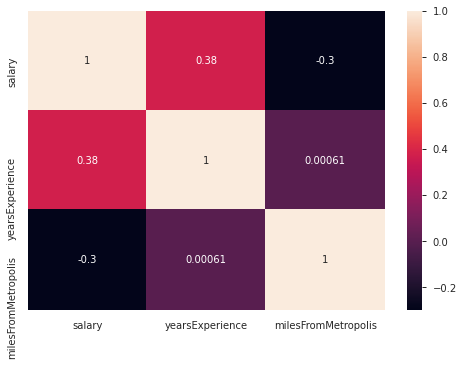

In [32]:
sns.heatmap(correlation_matrix, annot=True)
plt.show()

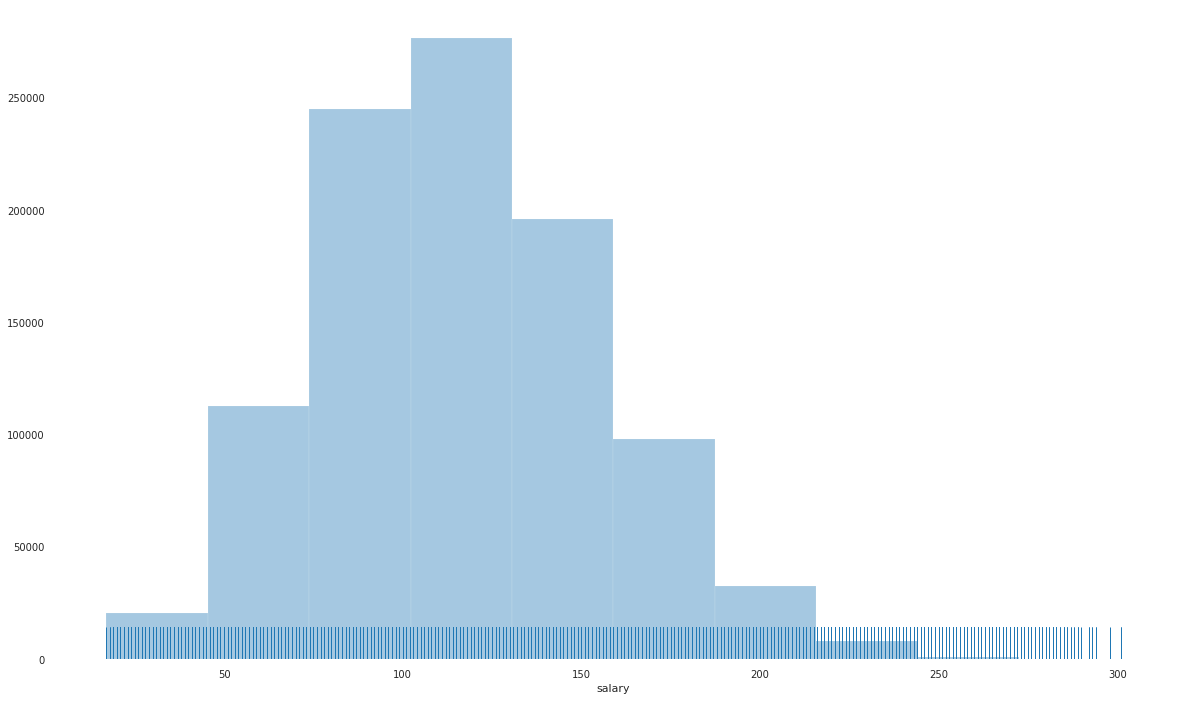

In [33]:
plt.figure(figsize=(20,12))
col = 'salary'
sns.distplot(train_data_clean[col], bins=10, kde=False, rug=True);

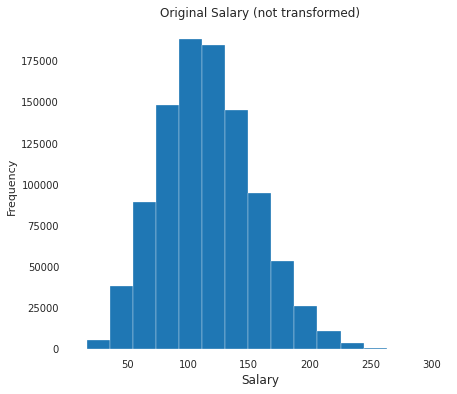

In [34]:
# Plot Fare Price Distribution
plt.subplot(1, 2, 1)
(train_data_clean['salary']).plot.hist(bins=15, figsize=(15, 6), edgecolor = 'white')
plt.xlabel('Salary', fontsize=12)
plt.title('Original Salary (not transformed)')
plt.savefig(os.path.join('../','visualizations','SalaryHistogram.png'))

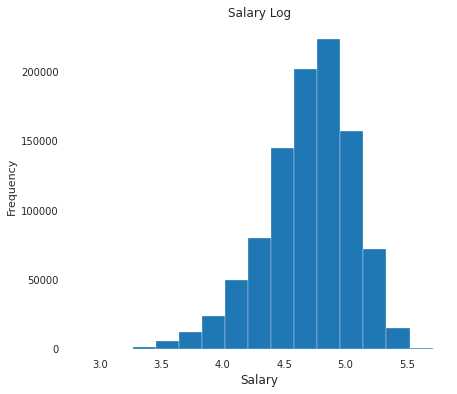

In [35]:
# Plot Fare Price Distribution
plt.subplot(1, 2, 1)
(np.log1p(train_data_clean['salary'])).plot.hist(bins=15, figsize=(15, 6), edgecolor = 'white')
plt.xlabel('Salary', fontsize=12)
plt.title('Salary Log')
plt.savefig(os.path.join('../','visualizations','SalaryLogHistogram.png'))

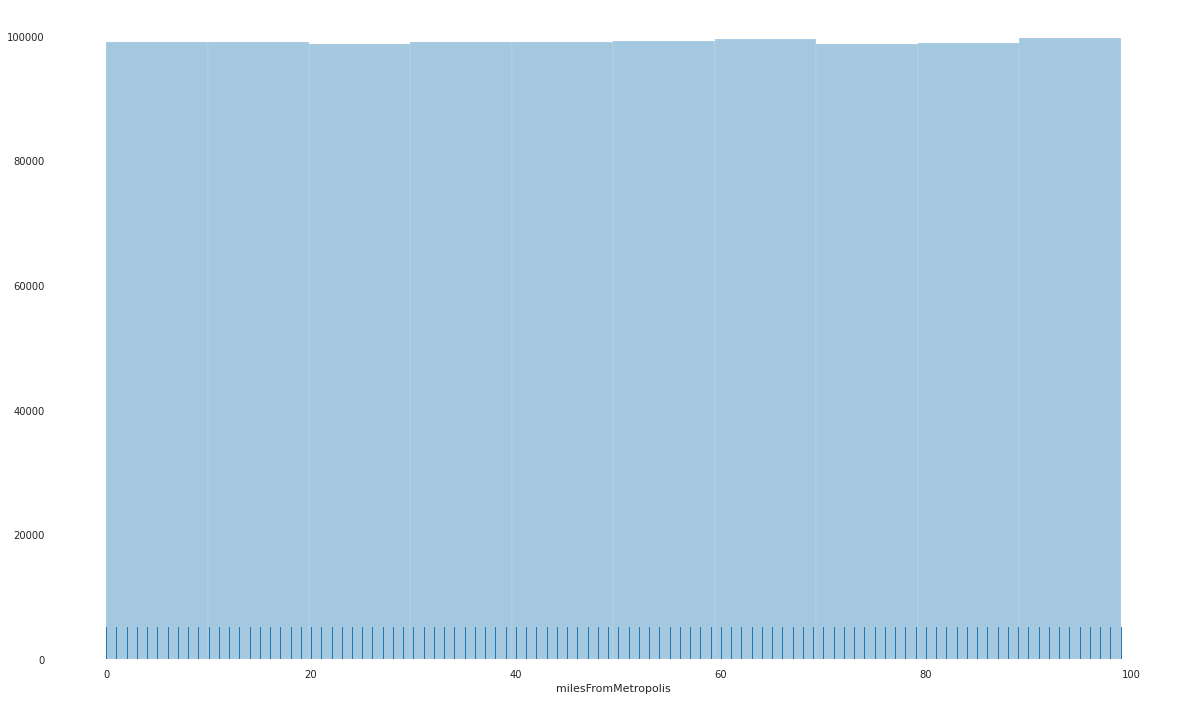

In [36]:
plt.figure(figsize=(20,12))
col = 'milesFromMetropolis'
sns.distplot(train_data_clean[col], bins=10, kde=False, rug=True);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

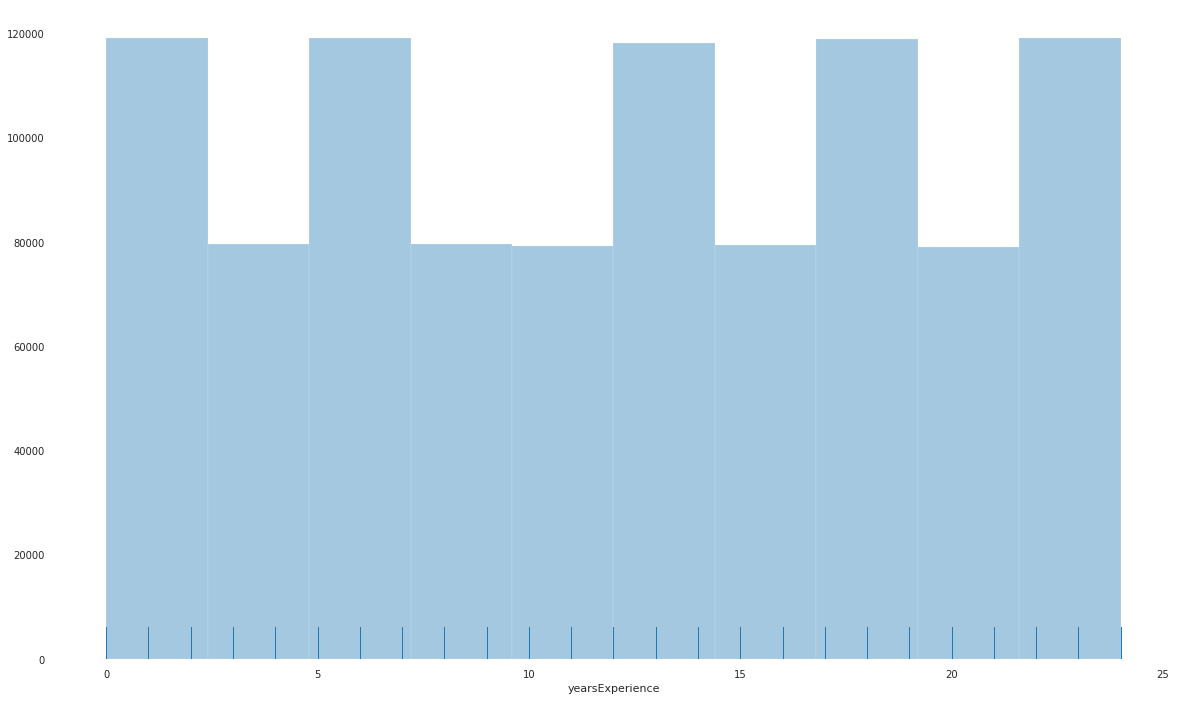

In [37]:
plt.figure(figsize=(20,12))
col = 'yearsExperience'
sns.distplot(train_data_clean[col], bins=10, kde=False, rug=True);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

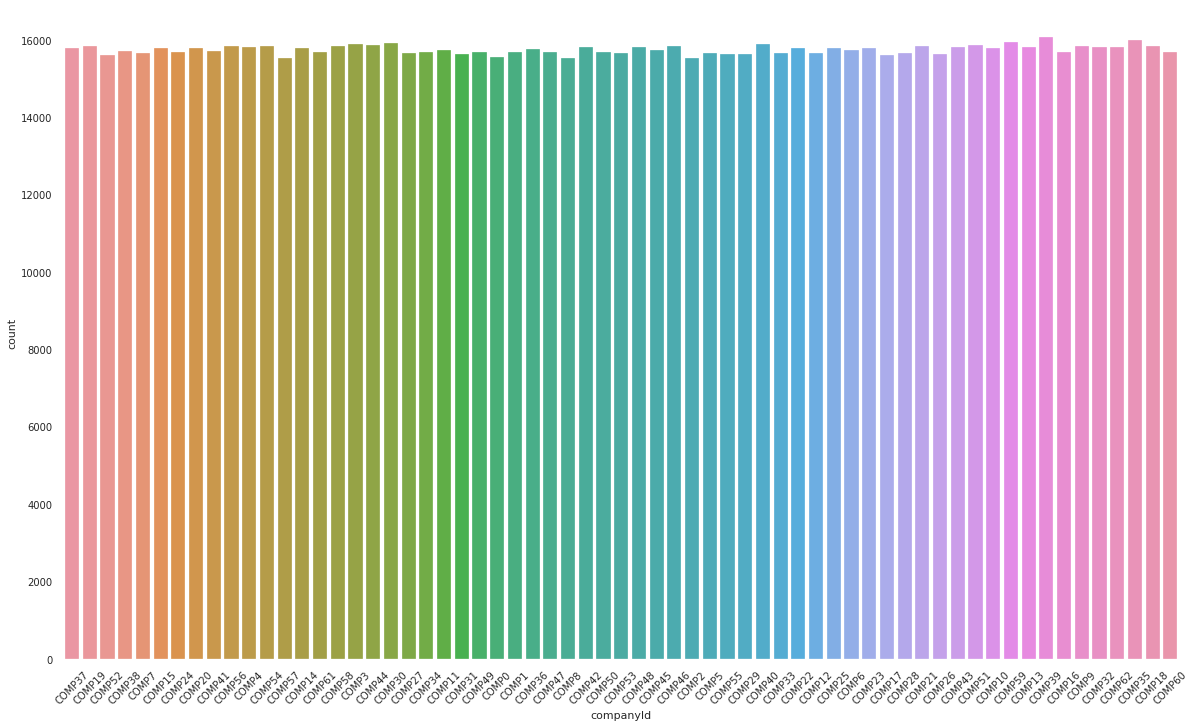

In [38]:
plt.figure(figsize=(20,12))
col = 'companyId'
chart = sns.countplot(train_data_clean[col])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

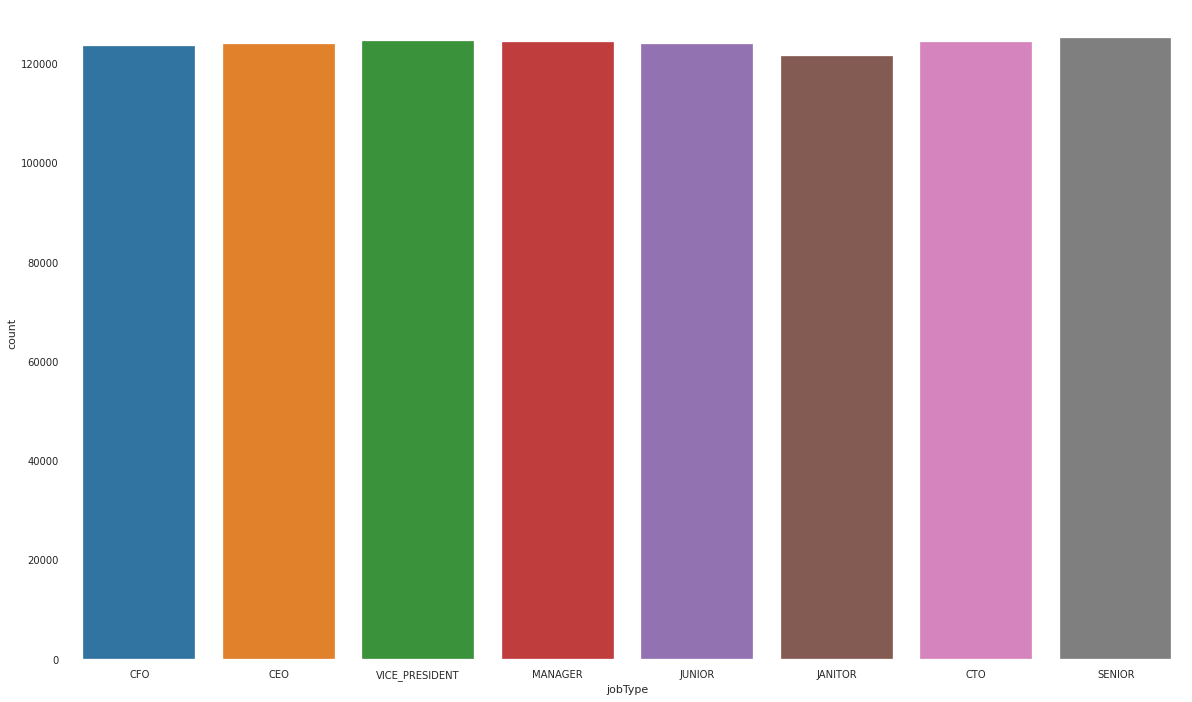

In [39]:
plt.figure(figsize=(20,12))
col = 'jobType'
sns.countplot(train_data_clean[col]);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

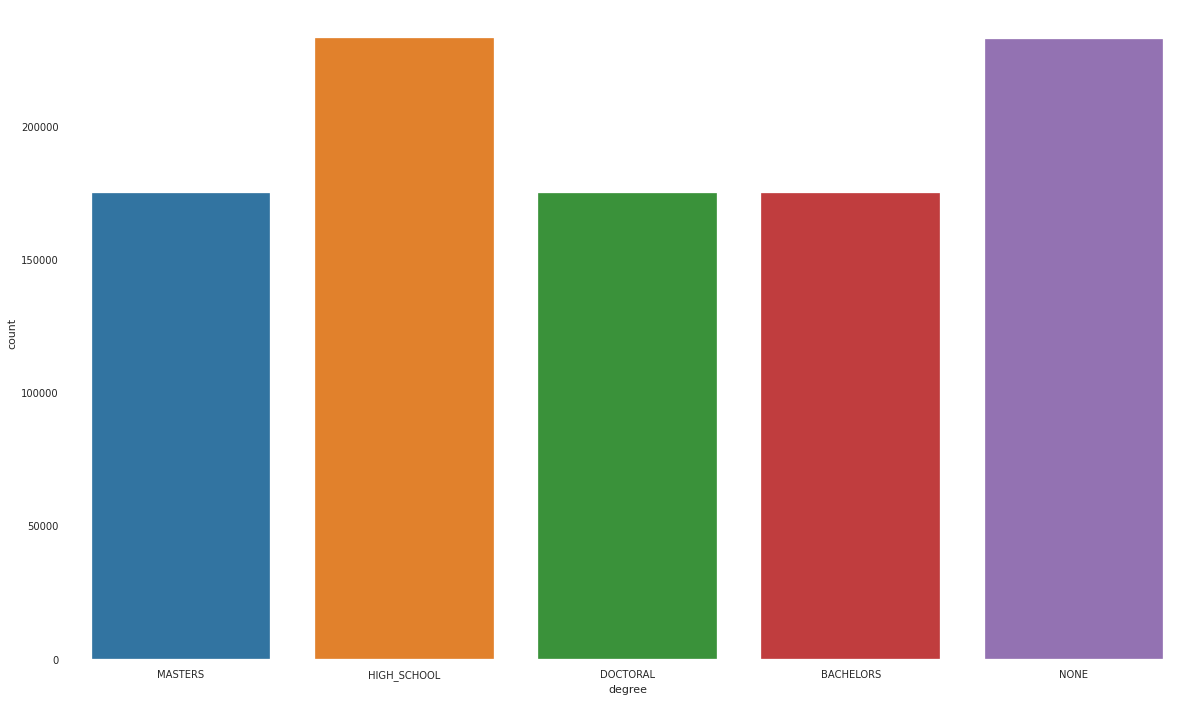

In [40]:
plt.figure(figsize=(20,12))
col = 'degree'
sns.countplot(train_data_clean[col]);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

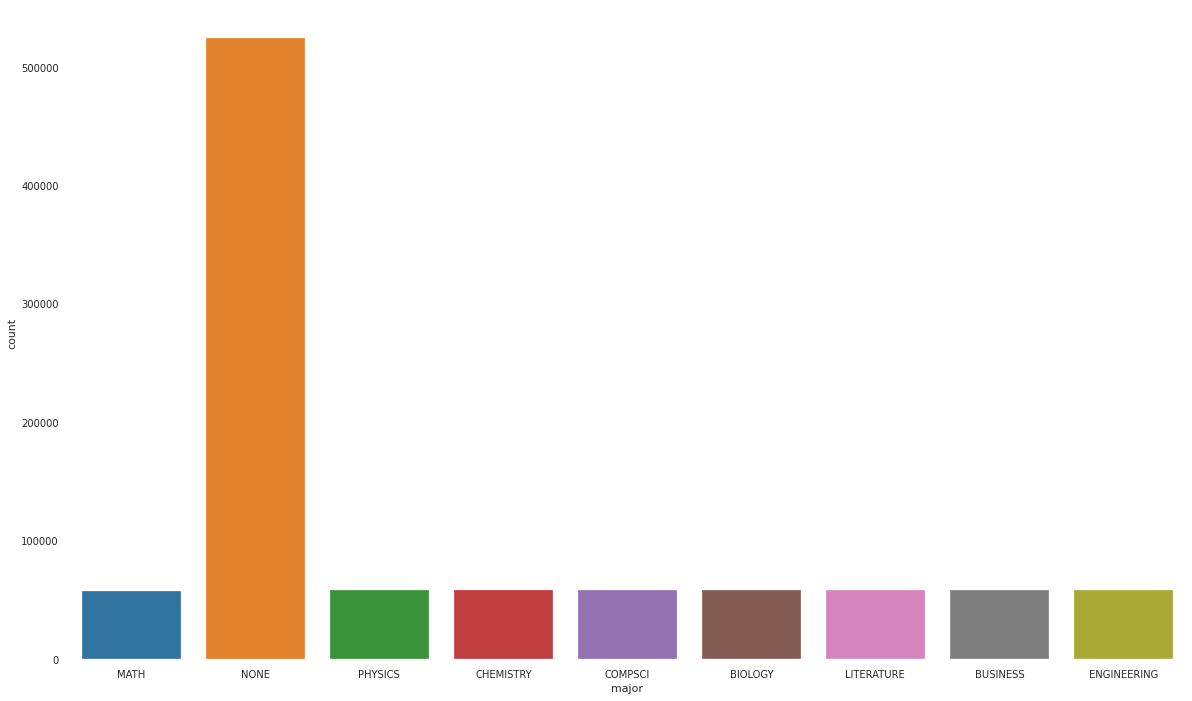

In [41]:
plt.figure(figsize=(20,12))
col = 'major'
sns.countplot(train_data_clean[col]);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

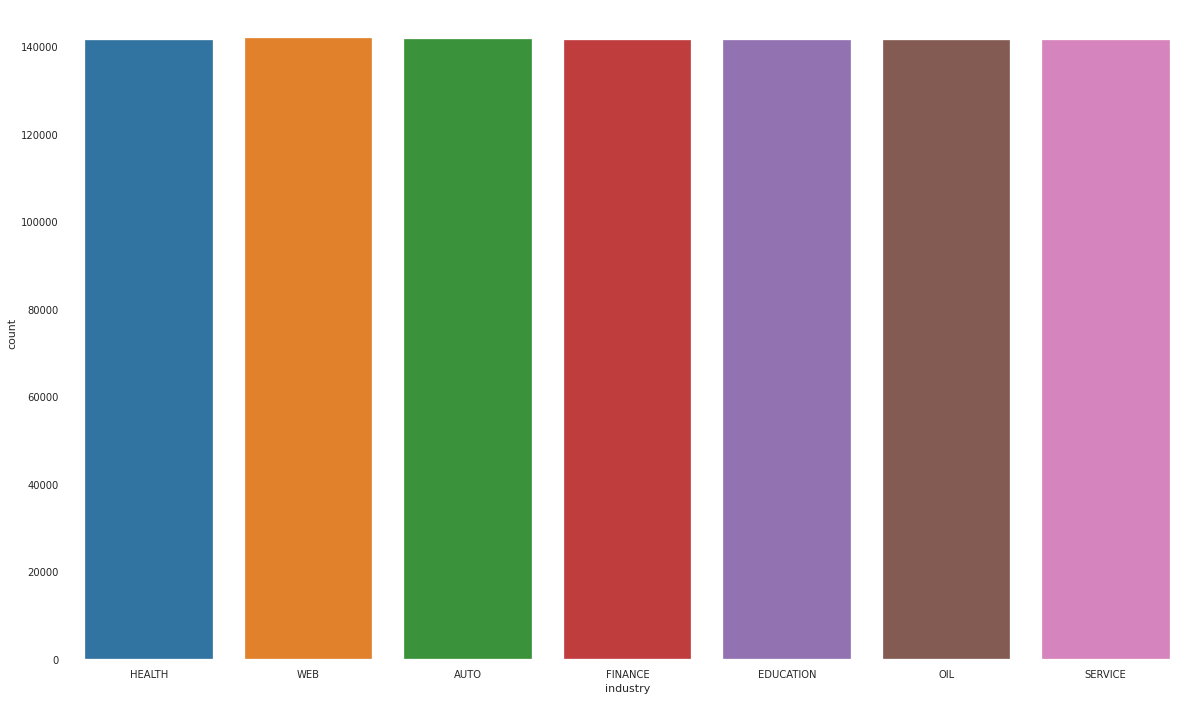

In [42]:
plt.figure(figsize=(20,12))
col = 'industry'
sns.countplot(train_data_clean[col]);
plt.savefig(os.path.join('../','visualizations',f"{col}_Histogram.png"))

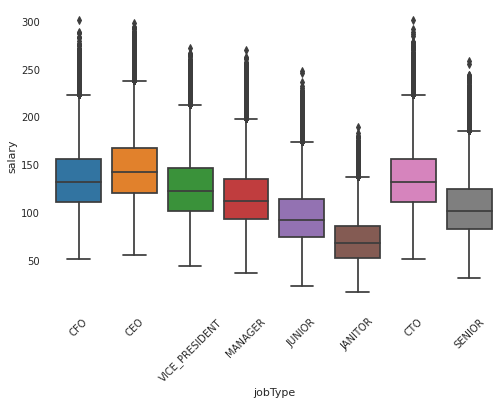

In [43]:
salary_info = sns.boxplot(x="jobType", y="salary", data=train_data_clean)
salary_info.set_xticklabels(salary_info.get_xticklabels(), rotation=45);
plt.savefig(os.path.join('../','visualizations','JobTypeVersusSalaryBoxPlot.png'))

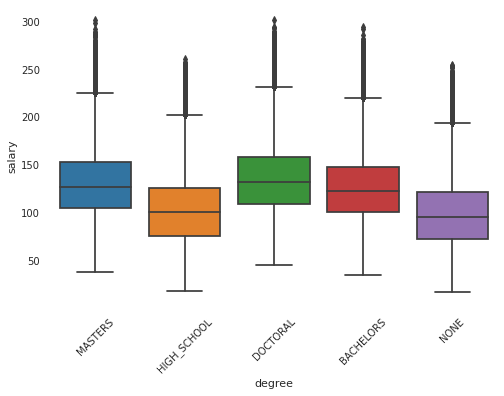

In [44]:
degree_info = sns.boxplot(x="degree", y="salary", data=train_data_clean)
degree_info.set_xticklabels(degree_info.get_xticklabels(), rotation=45);
plt.savefig(os.path.join('../','visualizations','DegreeVersusSalaryBoxPlot.png'))

In [45]:
train_data_clean.head()

salary companyId         jobType       degree      major industry  \
0   130.0    COMP37             CFO      MASTERS       MATH   HEALTH   
1   101.0    COMP19             CEO  HIGH_SCHOOL       NONE      WEB   
2   137.0    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH   
3   142.0    COMP38         MANAGER     DOCTORAL  CHEMISTRY     AUTO   
4   163.0     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS  FINANCE   

   yearsExperience  milesFromMetropolis  
0             10.0                 83.0  
1              3.0                 73.0  
2             10.0                 38.0  
3              8.0                 17.0  
4              8.0                 16.0

### ---- 5 Establish a baseline ----

In [46]:
# select a reasonable metric (MSE in this case)
# create an extremely simple model and measure its efficacy
# e.g. use "average salary" for each industry as your model and then measure MSE
# during 5-fold cross-validation
# add average 

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
    
#train_data_clean['salary'] = np.log1p(train_data_clean['salary'])
salary_pred = train_data_clean['salary']
k_folds = KFold(n_splits=5)
mean_squared_error_folds = []

for train, test in k_folds.split(salary_pred):
    
    # load train salary data
    train_salary = salary_pred.iloc[train]
    
    # generate average for train data
    average_salary = np.empty(len(train_salary))
    average_salary.fill(np.average(train_salary))
    
    # print the mean squarred error
    mean_squared_error_folds.append(mean_squared_error(train_salary, average_salary))
    #mean_squared_error(train_salary, average_salary)
    
print(np.average(mean_squared_error_folds))

1496.4989868651542


### ---- 6 Hypothesize solution ----

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

***The next three models that should be choosen for the solution would be an Tree Classification, XGboost Model, and a Artificial Neural networks. They are reasonable models to use as they will work with continous label. Additionally, the numerical values will be scaled such that additonal insight can be gather by looking at a smaller range of data, and the numerical value will be on a consistent scale. Additional features should be added for the c-level position as those should require more salary potential than others and advanced degrees (Masters and Doctorate) should be separated from the rest as well.*** 



Prior to adding running the data through a neural network, the data will be one-hot encoded.

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

#### --- Add new features ----

In [47]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model
degrees = train_data_clean['degree']
advanced_degrees = [
    1 if degree == 'DOCTORAL' else 1 if degree == 'MASTERS' else 0
    for degree in degrees
]
train_data_clean['IsAdvancedDegree'] = advanced_degrees

job_types = train_data_clean['jobType']
vp_or_c_levels = [
    1 if job_type == 'CEO' else 1 if job_type == 'CFO' else
    1 if job_type == 'CTO' else 1 if job_type == 'VICE_PRESIDENT' else 0
    for job_type in job_types
]
train_data_clean['VicePresidentOrAbove'] = vp_or_c_levels

#### --- Save data before manual encoding ----

In [48]:
# log transform salary before saving data to file
# train_data_clean['salary'] = np.log(train_data_clean['salary']) + 1

# add data to file such that additional steps can be done without re-running
train_data_clean.to_csv(os.path.join('../data','cleaned','train_data_clean.tar.gz'), compression='gzip', index=False)

#### --- Ordinal Encoding ----

In [103]:
# Perfrom Ordinal Encoding meaning that the order has a purpose
# create a dictionary to store the order
degree_ord_map = {'NONE': 1, 'HIGH_SCHOOL': 2, 'BACHELORS': 3, 'MASTERS': 4, 'DOCTORAL' : 5}

# # add a new column to the dataframe for ordinal encoding
train_data_clean['DegreeGroup_OE'] = train_data_clean['degree'].map(degree_ord_map)

# # show a few samples
train_data_clean[['degree','DegreeGroup_OE']].head()

degree  DegreeGroup_OE
0      MASTERS               4
1  HIGH_SCHOOL               2
2     DOCTORAL               5
3     DOCTORAL               5
4    BACHELORS               3

In [44]:
# Perfrom Ordinal Encoding meaning that the order has a purpose
# # create a dictionary to store the order
jobtype_ord_map = {
    'JANITOR': 1,
    'JUNIOR': 2,
    'SENIOR': 3,
    'MANAGER': 4,
    'VICE_PRESIDENT': 5,
    'CFO': 6,
    'CTO': 7,
    'CEO': 8
}

# # add a new column to the dataframe for ordinal encoding
train_data_clean['JobTypeGroup_OE'] = train_data_clean['jobType'].map(
    jobtype_ord_map)

# # show a few samples
train_data_clean[['jobType', 'JobTypeGroup_OE']].head()

jobType  JobTypeGroup_OE
0             CFO                6
1             CEO                8
2  VICE_PRESIDENT                5
3         MANAGER                4
4  VICE_PRESIDENT                5

#### --- Label Encoding ----

In [45]:
# Perform Label encoding on Major input feature
# add to train data clean data frame
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
major_labels = le.fit_transform(train_data_clean['major'])
train_data_clean['MajorGroup_LE'] = major_labels
                 
# show a few rows
train_data_clean[['major', 'MajorGroup_LE']]

major  MajorGroup_LE
0            MATH              6
1            NONE              7
2         PHYSICS              8
3       CHEMISTRY              2
4         PHYSICS              8
...           ...            ...
999995  CHEMISTRY              2
999996       NONE              7
999997       NONE              7
999998       NONE              7
999999       NONE              7

[991994 rows x 2 columns]

#### --- Ouantile Binning ----

In [46]:
# add quantile binning for both numeric input features
train_data_clean['miles_from_metro_label'] = pd.qcut(train_data_clean.milesFromMetropolis, 4, labels=[0.25, 0.5, 0.75, 1])
train_data_clean['years_experience_label'] = pd.qcut(train_data_clean.yearsExperience, 4, labels=[0.25, 0.5, 0.75, 1])

# show a few rows
train_data_clean[['milesFromMetropolis','miles_from_metro_label','yearsExperience', 'years_experience_label']].head()

milesFromMetropolis miles_from_metro_label  yearsExperience  \
0                 83.0                   1.00             10.0   
1                 73.0                   0.75              3.0   
2                 38.0                   0.50             10.0   
3                 17.0                   0.25              8.0   
4                 16.0                   0.25              8.0   

  years_experience_label  
0                   0.50  
1                   0.25  
2                   0.50  
3                   0.50  
4                   0.50

In [47]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991994 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   salary                  991994 non-null  float64 
 1   companyId               991994 non-null  object  
 2   jobType                 991994 non-null  object  
 3   degree                  991994 non-null  object  
 4   major                   991994 non-null  object  
 5   industry                991994 non-null  object  
 6   yearsExperience         991994 non-null  float64 
 7   milesFromMetropolis     991994 non-null  float64 
 8   IsAdvancedDegree        991994 non-null  int64   
 9   VicePresidentOrAbove    991994 non-null  int64   
 10  JobTypeGroup_OE         991994 non-null  int64   
 11  MajorGroup_LE           991994 non-null  int64   
 12  miles_from_metro_label  991994 non-null  category
 13  years_experience_label  991994 non-null  category
dtypes: c

In [48]:
# create dummy (one-hot encoded) columns for companyID and industry
company_industry_features = pd.get_dummies(train_data_clean[['companyId', 'industry']])
train_data_clean = pd.concat([train_data_clean, company_industry_features], axis=1)

# show a few rows
train_data_clean.head()



salary companyId         jobType       degree      major industry  \
0  5.867534    COMP37             CFO      MASTERS       MATH   HEALTH   
1  5.615121    COMP19             CEO  HIGH_SCHOOL       NONE      WEB   
2  5.919981    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH   
3  5.955827    COMP38         MANAGER     DOCTORAL  CHEMISTRY     AUTO   
4  6.093750     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS  FINANCE   

   yearsExperience  milesFromMetropolis  IsAdvancedDegree  \
0             10.0                 83.0                 1   
1              3.0                 73.0                 0   
2             10.0                 38.0                 1   
3              8.0                 17.0                 1   
4              8.0                 16.0                 0   

   VicePresidentOrAbove  ...  companyId_COMP7  companyId_COMP8  \
0                     1  ...                0                0   
1                     1  ...                0                0   
2                     1  ...                0                0   
3                     0  ...                0                0   
4                     1  ...                1                0   

  companyId_COMP9 industry_AUTO  industry_EDUCATION  industry_FINANCE  \
0               0             0                   0                 0   
1               0             0                   0                 0   
2               0             0                   0                 0   
3               0             1                   0                 0   
4               0             0                   0                 1   

   industry_HEALTH  industry_OIL  industry_SERVICE  industry_WEB  
0                1             0                 0             0  
1                0             0                 0             1  
2                1             0                 0             0  
3                0             0                 0             0  
4                0             0                 0             0  

[5 rows x 84 columns]

In [49]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991994 entries, 0 to 999999
Data columns (total 84 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   salary                  991994 non-null  float64 
 1   companyId               991994 non-null  object  
 2   jobType                 991994 non-null  object  
 3   degree                  991994 non-null  object  
 4   major                   991994 non-null  object  
 5   industry                991994 non-null  object  
 6   yearsExperience         991994 non-null  float64 
 7   milesFromMetropolis     991994 non-null  float64 
 8   IsAdvancedDegree        991994 non-null  int64   
 9   VicePresidentOrAbove    991994 non-null  int64   
 10  JobTypeGroup_OE         991994 non-null  int64   
 11  MajorGroup_LE           991994 non-null  int64   
 12  miles_from_metro_label  991994 non-null  category
 13  years_experience_label  991994 non-null  category
 14  comp

#### --- Dropping Original Columns ----

In [50]:
# # drop encoded columns and unnecessary columns
train_data_clean.drop([
    'milesFromMetropolis', 'yearsExperience', 'jobType', 'degree', 'major',
    'companyId', 'industry'
],
                      axis=1,
                      inplace=True)

# # standard column names for reading
train_data_clean.columns = map(str.capitalize, train_data_clean.columns)

In [51]:
# make sure they are gone from the dataframe
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991994 entries, 0 to 999999
Data columns (total 77 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Salary                  991994 non-null  float64 
 1   Isadvanceddegree        991994 non-null  int64   
 2   Vicepresidentorabove    991994 non-null  int64   
 3   Jobtypegroup_oe         991994 non-null  int64   
 4   Majorgroup_le           991994 non-null  int64   
 5   Miles_from_metro_label  991994 non-null  category
 6   Years_experience_label  991994 non-null  category
 7   Companyid_comp0         991994 non-null  uint8   
 8   Companyid_comp1         991994 non-null  uint8   
 9   Companyid_comp10        991994 non-null  uint8   
 10  Companyid_comp11        991994 non-null  uint8   
 11  Companyid_comp12        991994 non-null  uint8   
 12  Companyid_comp13        991994 non-null  uint8   
 13  Companyid_comp14        991994 non-null  uint8   
 14  Comp

In [52]:
# add data to file such that additional steps can be done without re-running
train_data_clean.to_csv(os.path.join('../','data','cleaned','train_data_clean_manual.tar.gz'), compression='gzip', index=False)

In [53]:
train_data_clean.columns.to_list()

['Salary',
 'Isadvanceddegree',
 'Vicepresidentorabove',
 'Jobtypegroup_oe',
 'Majorgroup_le',
 'Miles_from_metro_label',
 'Years_experience_label',
 'Companyid_comp0',
 'Companyid_comp1',
 'Companyid_comp10',
 'Companyid_comp11',
 'Companyid_comp12',
 'Companyid_comp13',
 'Companyid_comp14',
 'Companyid_comp15',
 'Companyid_comp16',
 'Companyid_comp17',
 'Companyid_comp18',
 'Companyid_comp19',
 'Companyid_comp2',
 'Companyid_comp20',
 'Companyid_comp21',
 'Companyid_comp22',
 'Companyid_comp23',
 'Companyid_comp24',
 'Companyid_comp25',
 'Companyid_comp26',
 'Companyid_comp27',
 'Companyid_comp28',
 'Companyid_comp29',
 'Companyid_comp3',
 'Companyid_comp30',
 'Companyid_comp31',
 'Companyid_comp32',
 'Companyid_comp33',
 'Companyid_comp34',
 'Companyid_comp35',
 'Companyid_comp36',
 'Companyid_comp37',
 'Companyid_comp38',
 'Companyid_comp39',
 'Companyid_comp4',
 'Companyid_comp40',
 'Companyid_comp41',
 'Companyid_comp42',
 'Companyid_comp43',
 'Companyid_comp44',
 'Companyid_comp

### ---- 8 Create models ----

#### Preprocessing

In [57]:
# load class
from helperFile import MachineLearning, random_tune
import os

# load data and set label
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), label='salary')
 
# perform preprocessing
numeric_columns =  ['yearsExperience', 'milesFromMetropolis']
category_columns = ['industry', 'jobType', 'degree']
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

#### Linear Regression

##### Categorical Features only

In [58]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.linear_model import LinearRegression
import logging
import os

# load data and set label
train_data = pd.read_csv(os.path.join('../data','cleaned','train_data_clean.tar.gz'), low_memory=False)
 
# log transform salary data
train_data['salary'] = np.log(train_data['salary']) + 1

# set X and y
X = train_data.drop('salary', axis=1)
y = train_data[['salary']]
        
# Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)    
    

ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
label_encode = LabelEncoder()
imputer = SimpleImputer(add_indicator=True, verbose=1)
scaler = StandardScaler()

category_columns = ['industry', 'degree', 'jobType', 'major']

# Make Transformer
preprocessing = make_column_transformer(
            (ohe, category_columns),
            remainder='drop')

    
start = time.time()
logging.info("Linear Regression Start")

# put model into an object
linear_regression = LinearRegression()

# Make pipeline
pipe = make_pipeline(preprocessing, linear_regression)        

# Fit model
pipe.fit(X_train, y_train.values.ravel())

# Score
score = pipe.score(X_test, y_test.values.ravel()) 

# set log for finishing
logging.info(f"Score for Linear Regression is {score}")
logging.info(f"Run Time for Linear Regression is {(time.time() - start) // 60} minutes")

# Print Best Score
score

0.5546921734397396

##### Numerical Features Only

In [15]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.linear_model import LinearRegression
import logging
import os

# load data and set label
train_data = pd.read_csv(os.path.join('../data','cleaned','train_data_clean.tar.gz'), low_memory=False)

# log transform salary data
train_data['salary'] = np.log(train_data['salary']) + 1

# set X and y
X = train_data.drop('salary', axis=1)
y = train_data[['salary']]
        
# Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)    
    

ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
label_encode = LabelEncoder()
imputer = SimpleImputer(add_indicator=True, verbose=1)
scaler = StandardScaler()

numeric_columns =  ['yearsExperience', 'milesFromMetropolis']

# Make Transformer
preprocessing = make_column_transformer(
            (make_pipeline(imputer,scaler), numeric_columns),
            remainder='drop')

    
start = time.time()
logging.info("Linear Regression Start Log Transform")

# put model into an object
linear_regression = LinearRegression()

# Make pipeline
pipe = make_pipeline(preprocessing, linear_regression)        

# Fit model
pipe.fit(X_train, y_train.values.ravel())

# Score
score = pipe.score(X_test, y_test.values.ravel()) 

# set log for finishing
logging.info(f"Score for Linear Regression is {score}")
logging.info(f"Run Time for Linear Regression is {(time.time() - start) // 60} minutes")

# Print Best Score
score

0.2173751510084717

##### include all features

In [1]:
import os
from helperFile import random_tune, MachineLearning, numeric_columns, category_columns

# store name to be use in results
model = 'LinearRegression'

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}"))  
 
# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# perform random forest using best parameters
score, mse = machine_learning.LinearRegression()

# calculate mse 

# print final model score
print(score, mse)

0.7395796919875216 389.4016080814103


#### Random Forest

##### tune random forest (max depth, n_estimators, max_features, min_samples_leaf)

In [2]:
from helperFile import random_tune, MachineLearning, numeric_columns, category_columns
from sklearn.ensemble import RandomForestRegressor

# store name to be use in results
model = 'RandomForest'

machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary'
                                   log_file=os.path.join('../logs', f"{model}"))

# set up pre-processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# store results as a list of tuples
results = []

# loop through each paramter and parameter value
for key, values in random_tune.items():
    # loop through each 
    for value in values:
        
        # set parameter and value to tune
        parameter = { key : value }
        
        # perform random forst
        score = machine_learning.RandomForestTune(parameter_dict=parameter)
        
        results.append((key, value, score))

/home/narquette/anaconda/envs/capstone/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/narquette/anaconda/envs/capstone/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/narquette/anaconda/envs/capstone/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/narquette/anaconda/envs/capstone/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably mea

#### Show Best parameters for Random Forest

In [3]:
# store best result to be used as parameter
best_results_dict = {}

# loop through all parameter keys
for key in random_tune.keys():
    
    # get the values for current key
    values = [val for val in results if val[0] == key]
    # get the score for current key
    scores = [val[2] for val in values]
    # get parameter for current key and max score
    best_score = [val for val in values if val[2] == max(scores)]
    # set diction with best parameter and parameter value
    best_results_dict[best_score[0][0]] = best_score[0][1]
    
# print out results
print(best_results_dict)

{'max_depth': 20, 'n_estimators': 100, 'max_features': 0.7, 'min_samples_leaf': 7}


#### Final, Tuned, Random Forest

In [1]:
import os
from helperFile import random_tune, MachineLearning, numeric_columns, category_columns
from sklearn.ensemble import RandomForestRegressor

# set model name
model = 'RandomForest'

# load data
machine_learning = MachineLearning(data=os.path.join('../data', 'cleaned', 'train_data_clean.tar.gz'),
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}"))

# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns,
                                               one_hot_cols=category_columns)

# set best_results_dict
best_results_dict = {'max_depth': 20, 'n_estimators': 100,
                     'max_features': .7, 'min_samples_leaf': 7}

# perform random forest using best parameters
score, mse = machine_learning.RandomForest(parameter_dict=best_results_dict)

# print final model score
print(score, mse)

0.7546346586630361 366.89019843828635


#### Tune XGBoost

In [1]:
# import tuneing parameters
import os
from helperFile import MachineLearning, xgb_tune, numeric_columns, category_columns

# set model name
model = 'XGBoost'

# load data
machine_learning = MachineLearning(data=os.path.join('../data', 'cleaned', 'train_data_clean.tar.gz'),
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}"))

# perform pre-processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns,
                                               one_hot_cols=category_columns)

# store results as a list of tuples
results = []

# loop through each paramter and parameter value
for key, values in xgb_tune.items():
    # loop through each
    for value in values:

        # set parameter and value to tune
        parameter = {key: value}

        # perform random forst
        score = machine_learning.XGboostTune(parameter_dict=parameter)

        results.append((key, value, score))

[14:32:26] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:33:23] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification.

[14:49:34] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:34] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:58:23] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:19] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:19] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification.

#### Show Best Parameters XGBoost

In [3]:
# store best result to be used as parameter
best_results_dict = {}

# loop through all parameter keys
for key in xgb_tune.keys():

    # get the values for current key
    values = [val for val in results if val[0] == key]
    # get the score for current key
    scores = [val[2] for val in values]
    # get parameter for current key and max score
    best_score = [val for val in values if val[2] == max(scores)]
    # set diction with best parameter and parameter value
    best_results_dict[best_score[0][0]] = best_score[0][1]

# print out results
print(best_results_dict)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


#### Final, Tuned XGBoost

In [6]:
import os
from helperFile import xgb_tune, MachineLearning, numeric_columns, category_columns
import xgboost as xgb

# set model name
model = 'XGBoost' 

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}"))
 
# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# # set best_results_dict
best_results_dict = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

# # perform random forest using best parameters
score, mse = machine_learning.XGboost(parameter_dict=best_results_dict)
        
# # print final model score
print(score, mse)

[16:39:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.7556651155930785 365.34937549448637


#### Tune LGBoost

In [69]:
# import tuneing parameters
import os
from helperFile import MachineLearning, lgb_tune, numeric_columns, category_columns

# set model name
model = 'LGBoost'

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}"))
 
# set columns for preprocessing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# store results as a list of tuples
results = []

# loop through each paramter and parameter value
for key, values in lgb_tune.items():
    # loop through each 
    for value in values:
        
        # set parameter and value to tune
        parameter = { key : value }
        
        # perform random forst
        score = machine_learning.LGboost(parameter_dict=parameter)
        
        results.append((key, value, score))

#### Show Best Parameters LGBoost

In [70]:
# store best result to be used as parameter
best_results_dict = {}

# loop through all parameter keys
for key in lgb_tune.keys():
    
    # get the values for current key
    values = [val for val in results if val[0] == key]
    # get the score for current key
    scores = [val[2] for val in values]
    # get parameter for current key and max score
    best_score = [val for val in values if val[2] == max(scores)]
    # set diction with best parameter and parameter value
    best_results_dict[best_score[0][0]] = best_score[0][1]
    
# print out results
print(best_results_dict)

{'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 126, 'n_estimators': 100, 'min_data_in_leaf': 100}


#### Final, Tuned LGBoost

In [8]:
import os
from helperFile import xgb_tune, MachineLearning, numeric_columns, category_columns

# set model name
model = 'LGBoost'

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}"))
 
# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# set best_results_dict
best_results_dict = {'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 126, 'n_estimators': 100, 'min_data_in_leaf': 100}

# perform random forest using best parameters
score, mse = machine_learning.LGboost(parameter_dict=best_results_dict)
        
# print final model score
print(score, mse)

0.7603138576766169 358.39819854249976


### ---- 9 Test models ----

#### Linear Regression Cross Validation

In [1]:
# do 5-fold cross validation on models and measure MSE
import os
import numpy as np
from helperFile import MachineLearning, numeric_columns, category_columns

# store name to be use in results
model = 'LinearRegression'

# store results for all models
cv_results = {}

# load data
machine_learning = MachineLearning(data=os.path.join('../data', 'cleaned', 'train_data_clean.tar.gz'),
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation")) 

# setup pre processing
preprocessing=machine_learning.PreProcessing(scale_cols = numeric_columns,
                                               one_hot_cols = category_columns)

# perform random forest using best parameters
mse = machine_learning.LinearRegression(cross_validation = True)

# print final model score
cv_results[model] = np.min(mse)

#### Random Forest Cross Validation

In [2]:
import os
import numpy as np
from helperFile import MachineLearning, numeric_columns, category_columns

# store name to be use in results
model = 'RandomForest'

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation")) 
# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# set best_results_dict
best_results_dict = {'max_depth': 20, 'n_estimators': 100,
                     'max_features': .7, 'min_samples_leaf': 7}

# perform random forest using best parameters
mse = machine_learning.RandomForest(parameter_dict=best_results_dict, cross_validation=True)

# print final model score
cv_results[model] = np.min(mse)

#### XGboost Cross Validation

In [3]:
import os
import numpy as np
from helperFile import MachineLearning, numeric_columns, category_columns

# store name to be use in results
model = 'XGboost'

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation"))
 
# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# set best_results_dict
best_results_dict = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

# perform random forest using best parameters
mse = machine_learning.XGboost(parameter_dict=best_results_dict, cross_validation=True)

# print final model score
cv_results[model] = np.min(mse)

[18:44:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:45:00] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:45:44] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


#### LGboost Cross Validation

In [1]:
import os
import numpy as np
from helperFile import MachineLearning, numeric_columns, category_columns

In [4]:
# store name to be use in results
model = 'LGboost'

# load data
machine_learning = MachineLearning(data=os.path.join('../data','cleaned','train_data_clean.tar.gz'), 
                                   label='salary',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation"))
 
# setup pre processing
preprocessing = machine_learning.PreProcessing(scale_cols=numeric_columns, 
                                               one_hot_cols=category_columns)

# set best_results_dict
best_results_dict = {'max_depth': 20, 'n_estimators': 100, 'max_features': 'auto', 'min_samples_leaf': 20}

# perform random forest using best parameters
mse = machine_learning.LGboost(parameter_dict=best_results_dict, cross_validation=True)

# print final model score
cv_results[model] = np.min(mse)

#### Show Model Results

In [5]:
import pandas as pd
model_dataframe = pd.DataFrame()
model_dataframe['Model'] = cv_results.keys()
model_dataframe['MeanSquaredError'] = cv_results.values()
model_dataframe

Model  MeanSquaredError
0  LinearRegression        386.671790
1      RandomForest        363.515117
2           XGboost        363.107490
3           LGboost        356.793879

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "production" model


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset


### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data